# Example: PyRayHF Raytracing Verification Example

This example demonstrates the verification of PyRayHF ray-tracing solvers
by comparing the ray trajectories computed using multiple forward operators:
- Cartesian Snell’s Law
- Spherical Snell’s Law
- Cartesian Gradient Method
- Spherical Gradient Method

Each solver is run for identical transmission conditions (frequency, elevation,
and ionospheric background), and the resulting ray paths are plotted together
for direct visual comparison. The example illustrates the consistency among
methods in their overlapping regimes and highlights geometric differences
that arise from curvature and horizontal gradients.

The produced figures serve as a validation benchmark for both geometric
and dispersion accuracy within the PyRayHF framework.


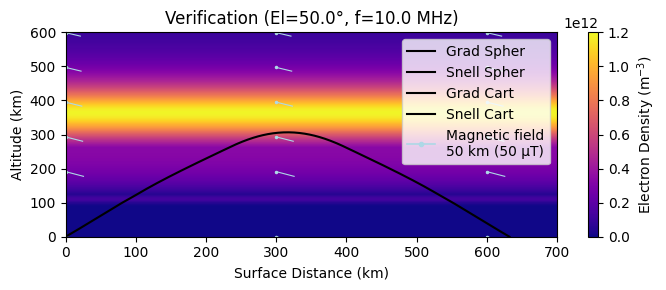

--------------------------------------------------
Spherical Gradient Raytracing X-mode:
--------------------------------------------------
Group Path (km):  909.0052993843551
Group delay (sec):  0.0035117709686711303
Ground Range (km):  632.1002041001278
x midpoint (km):  315.91123896337433
z midpoint (km):  306.48078040010387
--------------------------------------------------
Spherical Snell's Raytracing X-mode:
--------------------------------------------------
Group Path (km):  921.1219246027097
Group delay (sec):  0.0035278471798738994
Ground Range (km):  673.2540878901069
x midpoint (km):  336.62704394505346
z midpoint (km):  302.53164985393204
--------------------------------------------------
Cartesian Gradient Raytracing X-mode:
--------------------------------------------------
Group Path (km):  920.0357367675576
Group delay (sec):  0.0035258492672866574
Ground Range (km):  671.0712329121054
x midpoint (km):  346.52308962434364
z midpoint (km):  301.85202366603556
-----------

In [14]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import constants
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_mup_function
from PyRayHF.library import build_refractive_index_interpolator_spherical
from PyRayHF.library import build_refractive_index_interpolator_cartesian
from PyRayHF.library import trace_ray_spherical_gradient
from PyRayHF.library import trace_ray_spherical_snells
from PyRayHF.library import trace_ray_cartesian_snells
from PyRayHF.library import trace_ray_cartesian_gradient
import time

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Calculate plasma parameters
X = find_X(Ne_grid, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

# X-mode
mode = "X"
mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)

# Build a function for spherical interpolation of mup
mup_func_spherical = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="spherical",
                                        R_E=1e10)

# Build interpolator from spherical μ grid
n_and_grad_spherical = build_refractive_index_interpolator_spherical(z_grid,
                                                                     x_grid,
                                                                     mu,
                                                                     R_E=1e10)

# Build interpolator from mup grid
n_and_grad = build_refractive_index_interpolator_cartesian(z_grid, x_grid, mu)

# Build μ' (group) for delay only
mup_func_cartesian = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="cartesian")

# Trace Using Gradient Method in Spherical 2-D Raytracing X-mode
result_GS = trace_ray_spherical_gradient(n_and_grad_rphi=n_and_grad_spherical,
                                         x0_km=0.0,
                                         z0_km=0.0,
                                         elevation_deg=elevation_deg,
                                         s_max_km=4000.,
                                         mup_func=mup_func_spherical,
                                         R_E=1e10)


# Trace Using Snell's Law Cartesian 2-D Raytracing X-mode
result_SC = trace_ray_cartesian_snells(f0_Hz=f0_Hz,
                                       elevation_deg=elevation_deg,
                                       alt_km=alt_km,
                                       Ne=Ne,
                                       Babs=Babs,
                                       bpsi=bpsi,
                                       mode=mode)

# Trace Using Gradient Method in Cartesian 2-D Raytracing X-mode
result_GC = trace_ray_cartesian_gradient(n_and_grad=n_and_grad,
                                         x0_km=0.0,
                                         z0_km=0.0,
                                         elevation_deg=elevation_deg,
                                         s_max_km=4000.0,
                                         max_step_km=5.0,
                                         z_max_km=600.0,
                                         x_min_km=0.0,
                                         x_max_km=1000.0,
                                         mup_func=mup_func_cartesian)

# Trace Using Snell's Law Spherical 2-D Raytracing X-mode
result_SS = trace_ray_spherical_snells(f0_Hz=f0_Hz,
                                       elevation_deg=elevation_deg,
                                       alt_km=alt_km,
                                       Ne=Ne,
                                       Babs=Babs,
                                       bpsi=bpsi,
                                       mode=mode,
                                       R_E=1e10)

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_xlim(0, 700)
ax.set_ylim(0, 600)
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Surface Distance (km)')

# --- Electron density background
vmin, vmax = 0, 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                   cmap='plasma', vmin=vmin, vmax=vmax)

# --- Magnetic field visualization (simple line segments with dots)
# Babs is in Tesla (≈3–6e-5), convert to relative visual length
B_scale = 1e6  # empirical scaling factor to make lines a few tens of km long
Bx = Babs * np.sin(np.deg2rad(bpsi)) * B_scale
Bz = -Babs * np.cos(np.deg2rad(bpsi)) * B_scale

# Subsample altitudes for clarity
step_z = max(1, len(alt_km)//5)
z_sample = alt_km[::step_z]
Bx_sample = Bx[::step_z]
Bz_sample = Bz[::step_z]

# Repeat horizontally every 300 km
x_spacing = 300  # km
x_repeat = np.arange(0, ax.get_xlim()[1], x_spacing)

for x_offset in x_repeat:
    for zs, bx, bz in zip(z_sample, Bx_sample, Bz_sample):
        xs, xe = x_offset, x_offset + bx
        ze = zs + bz
        ax.plot([xs, xe], [zs, ze], color='lightblue', lw=0.8)
        ax.plot(xs, zs, 'o', color='lightblue', ms=1.5)

# --- Plot the actual ray paths
line_GS, = ax.plot(result_GS['x'], result_GS['z'], c='black', lw=1.5, label='Grad Spher')
# line_SS, = ax.plot(result_SS['x'], result_SS['z'], c='black', lw=1.5, label='Snell Spher')
# line_GC, = ax.plot(result_GC['x'], result_GC['z'], c='black', lw=1.5, label='Grad Cart')
# line_SC, = ax.plot(result_SC['x'], result_SC['z'], c='black', lw=1.5, label='Snell Cart')

# --- Add custom magnetic field legend handle
B_ref = 50e-6  # 50 µT reference
line_length_km = B_ref * B_scale  # visible line length
legend_line = Line2D([0, 1], [0, 0], color='lightblue', lw=1.2,
                     marker='o', markersize=3,
                     label=f'Magnetic field\n{line_length_km:.0f} km (50 µT)')

# --- Labels, colorbar, legend
ax.set_title(f"Verification (El={elevation_deg:.1f}°, f={f0_Hz/1e6:.1f} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax, ticks=color_ticks)

ax.legend(handles=[line_GS, line_SS, line_GC, line_SC, legend_line], loc='upper right')

plt.tight_layout()
plt.savefig(local_dir + 'Verification.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


print('--------------------------------------------------')
print('Spherical Gradient Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_GS['group_path_km'])
print('Group delay (sec): ', result_GS['group_delay_sec'])
print('Ground Range (km): ', result_GS['ground_range_km'])
print('x midpoint (km): ', result_GS['x_midpoint'])
print('z midpoint (km): ', result_GS['z_midpoint'])

print('--------------------------------------------------')
print('Spherical Snell\'s Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_SS['group_path_km'])
print('Group delay (sec): ', result_SS['group_delay_sec'])
print('Ground Range (km): ', result_SS['ground_range_km'])
print('x midpoint (km): ', result_SS['x_midpoint'])
print('z midpoint (km): ', result_SS['z_midpoint'])

print('--------------------------------------------------')
print('Cartesian Gradient Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_GC['group_path_km'])
print('Group delay (sec): ', result_GC['group_delay_sec'])
print('Ground Range (km): ', result_GC['ground_range_km'])
print('x midpoint (km): ', result_GC['x_midpoint'])
print('z midpoint (km): ', result_GC['z_midpoint'])

print('--------------------------------------------------')
print('Cartesian Snell\'s Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_SC['group_path_km'])
print('Group delay (sec): ', result_SC['group_delay_sec'])
print('Ground Range (km): ', result_SC['ground_range_km'])
print('x midpoint (km): ', result_SC['x_midpoint'])
print('z midpoint (km): ', result_SC['z_midpoint'])
